In [189]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import rasterio
from rasterio.transform import from_origin
import torch.nn.functional as F
import random
import shutil
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from segmentation_models_pytorch import utils
import segmentation_models_pytorch as smp
import cv2
from tqdm import tqdm
from typing import List, Optional
from rasterio.windows import Window
import re


### Сиды

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Константы

In [5]:
PALLETE = [
        [0, 0, 0],
        [0, 0, 255],
        ]


ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


EPOCHS = 15
BATCH_SIZE = 32
ID =5

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох
 
SIZE = 256
CHANELS = 10
OVERLAP = 0
loss = utils.losses.DiceLoss()

CLASSES = [
    "background",
    "water"
]

# Вся визуализация

In [6]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))
def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)
def convert(im_path):
    
    with rasterio.open(im_path) as fin:
        red = fin.read(3)
        green = fin.read(2)
        blue = fin.read(1)

    red_b = brighten(red)
    blue_b = brighten(blue)
    green_b = brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    return np.dstack((blue_b, green_b, red_b)), np.dstack((red_bn, green_bn, blue_bn))

In [7]:
def plot_tensor_image(tensor_image: torch.Tensor) -> None:
    
    bgr_image = tensor_image[0, :3] 
    rgb_image = bgr_image[[2, 1, 0], :, :]  
    
    rgb_image_normalized = brighten(rgb_image)
    rgb_image_normalized = normalize(rgb_image_normalized)
   
    rgb_image_np = rgb_image_normalized.permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image_np)
    plt.title("RGB Image (Channels 1-3)")
    plt.axis("off")
    plt.show()

    
def plot_tensor_masks(mask: torch.Tensor) -> None:
    plt.figure(figsize=(10, 10))
    mask = mask.squeeze().numpy()  
    plt.imshow(mask, cmap='gray') 
    plt.colorbar()  
    plt.title('Visualization of the Tensor')
    plt.axis('off')  
    plt.show()


def plot_tensor(tensor_image: torch.Tensor, mask: torch.Tensor) -> None:

    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 

    #Изображение
    tensor_image = tensor_image.squeeze(0)
    bgr_image = tensor_image[:3]  
  
    rgb_image = bgr_image[[2, 1, 0], :, :]  
    rgb_image_normalized = brighten(rgb_image)
    rgb_image_normalized = normalize(rgb_image_normalized)

    rgb_image_np = rgb_image_normalized.permute(1, 2, 0).cpu().numpy()

    axes[0].imshow(rgb_image_np)
    axes[0].set_title("RGB Image (Channels 1-3)")
    axes[0].axis("off")

    pal = [value for color in PALLETE for value in color]
    mask_np = mask.squeeze(0).squeeze(0).numpy()

    print("Mask shape before conversion:", mask_np.shape)  
    mask_np = mask_np.astype(np.uint8)  
    mask_image = Image.fromarray(mask_np, mode='P')
    mask_image.putpalette(pal)

    axes[1].imshow(mask_image)
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.show()
def plot_results(tensor_image: torch.Tensor, mask: torch.Tensor, pred_mask: torch.Tensor) -> None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 10)) 

    #Изображение
    tensor_image = tensor_image.squeeze(0)
    bgr_image = tensor_image[:3]  
  
    rgb_image = bgr_image[[2, 1, 0], :, :]  
    rgb_image_normalized = brighten(rgb_image)
    rgb_image_normalized = normalize(rgb_image_normalized)

    rgb_image_np = rgb_image_normalized.permute(1, 2, 0).cpu().numpy()

    axes[0].imshow(rgb_image_np)
    axes[0].set_title("RGB Image (Channels 1-3)")
    axes[0].axis("off")

    pal = [value for color in PALLETE for value in color]
    mask_np = mask.squeeze(0).squeeze(0).numpy()

    mask_np = mask_np.astype(np.uint8)  
    mask_image = Image.fromarray(mask_np, mode='P')
    mask_image.putpalette(pal)

    axes[1].imshow(mask_image)
    axes[1].set_title("Mask")
    axes[1].axis("off")

    pred_mask_np = pred_mask.squeeze(0).squeeze(0).numpy()

    pred_mask_np = pred_mask_np.astype(np.uint8)  
    pred_mask_image = Image.fromarray(pred_mask_np, mode='P')
    pred_mask_image.putpalette(pal)
    axes[2].imshow(pred_mask_image)
    axes[2].set_title("Predict")
    axes[2].axis("off")


    plt.show()


def plot_data(image_path, mask_path):
    plt.figure(figsize=(25, 25))
    pal = [value for color in PALLETE for value in color]

    plt.subplot(1, 2, 1)
    _, img = convert(image_path)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('P')
    mask.putpalette(pal)
    plt.imshow(mask)
    plt.show()

### Создание плиток из 1 файла

In [8]:
def get_tiles_with_overlap(image_width: int, image_height: int, 
                           tile_size: int, overlap: int) -> List[Window]:

    step_size = tile_size - overlap
    tiles = []
    for y in range(0, image_height, step_size):
        for x in range(0, image_width, step_size):
            window = Window(x, y, tile_size, tile_size)
           
            window = window.intersection(Window(0, 0, image_width, image_height))
            tiles.append(window)
    return tiles

def save_tile(src_dataset: rasterio.io.DatasetReader, window: Window, 
              output_folder: str, tile_index: int, image_id: int) -> None:

    transform = src_dataset.window_transform(window)
    tile_data = src_dataset.read(window=window)
    
    profile = src_dataset.profile
    profile.update({
        'driver': 'GTiff',
        'height': window.height,
        'width': window.width,
        'transform': transform
    })
    
    output_filename = os.path.join(output_folder, f"tile_{image_id}_{tile_index}.tif")
    with rasterio.open(output_filename, 'w', **profile) as dst:
        dst.write(tile_data)
        
def split_image(image_path: str, output_folder: str, mask_path: Optional[str] = None, 
                tile_size: int = 512, overlap: int = 0, image_id: int = 20) -> None:
    with rasterio.open(image_path) as src_image:
        image_width = src_image.width
        image_height = src_image.height

       
        images_folder = os.path.join(output_folder, 'images')
        os.makedirs(images_folder, exist_ok=True)

        if mask_path:
            masks_folder = os.path.join(output_folder, 'masks')
            os.makedirs(masks_folder, exist_ok=True)

        tiles = get_tiles_with_overlap(image_width, image_height, tile_size, overlap)

        if mask_path:
            with rasterio.open(mask_path) as src_mask:
                for idx, window in tqdm(enumerate(tiles)):
                    save_tile(src_image, window, images_folder, idx, image_id)
                    save_tile(src_mask, window, masks_folder, idx, image_id)
        else:
            for idx, window in tqdm(enumerate(tiles)):
                save_tile(src_image, window, images_folder, idx, image_id)

### Считываение данных и создание Dataloader

In [9]:
import numpy as np

def image_padding(image, target_size=SIZE, constant_value=255):
    height, width = image.shape[1:3]
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_image = np.pad(image, 
                          ((0, 0), (0, pad_height), (0, pad_width)), 
                          mode='constant', constant_values=constant_value)
    return padded_image

def mask_padding(mask, target_size=SIZE, constant_value=-1):
    height, width = mask.shape
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_mask = np.pad(mask, 
                         ((0, pad_height), (0, pad_width)), 
                         mode='constant', constant_values=constant_value)
    return padded_mask




def get_data_list(img_path, delete: Optional[bool] = True):
    name = []
    for _, _, filenames in os.walk(img_path):  
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

  
    df = pd.DataFrame(name, columns=['id'])
    
    df['number'] = df['id'].str.extract(r'_(\d+)$')[0].astype(int)

    df = df.sort_values(by=['number']).reset_index(drop=True)

    sorted_names = df['id'].values

    if delete:
        return np.delete(sorted_names, 0)
    else:
        return sorted_names

#### WaterData

In [10]:
class WaterDataset(Dataset):
    def __init__(self, img_path, mask_path, file_names):
        self.img_path = img_path
        self.mask_path = mask_path
        self.file_names = file_names

    def __len__(self):
            return len(self.file_names)

    def __getitem__(self, idx):
        with rasterio.open(self.img_path + self.file_names[idx] + '.tif') as fin:
            image = fin.read()
        image = image_padding(image).astype(np.float32)

        with rasterio.open(self.mask_path + self.file_names[idx] + '.tif') as fin:
            mask = fin.read(1)
        mask = mask_padding(mask)
         

        # Преобразуем тип данных изображения в float32
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        # Преобразуем тип данных маски в long
        mask = mask.astype(np.uint8)
        mask = torch.from_numpy(mask).long()
        mask = mask.unsqueeze(0)
        


        return image, mask

### Предсказание 

In [380]:
image_path = f'train\images/{ID}.tif'
with rasterio.open(image_path) as src_image:
        IMG_WIDTH = src_image.width
        IMG_HEIGHT = src_image.height

In [381]:
def image_padding_predict(image, target_size=SIZE):
    height, width = image.shape[1:3]
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_image = np.pad(image, ((0, 0), (0, pad_height),
                                  (0, pad_width)), mode='reflect')
    return padded_image, (height, width)  

In [382]:
data_list = get_data_list(f'Buffer/images/', delete=False)
best_model = torch.jit.load('modeels/Linknet.pt', map_location=DEVICE)

pred_ds = WaterDataset(
    img_path=f'Buffer/images/',
    mask_path=f'Buffer_masks/images/',
    file_names=data_list
)

predicted_masks = []
for i in range(len(data_list)):
    image, _ = pred_ds[i]
    image, original_size = image_padding_predict(image)
    image = image.astype(np.float32)
    x_tensor = image.to(DEVICE).unsqueeze(0) if isinstance(image, torch.Tensor) else torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    binary_output = (pr_mask > 0.5).astype(int)
    binary_output = binary_output[:original_size[0], :original_size[1]]
    predicted_masks.append(torch.from_numpy(binary_output))

In [387]:
def reconstruct_image_from_tiles(tiles, image_height, image_width, tile_size, overlap):

    step_size = tile_size - overlap
    reconstructed_image = np.zeros((image_height, image_width), dtype=np.float32)
    weight_map = np.zeros((image_height, image_width), dtype=np.float32)

    index = 0
    for y in range(0, image_height, step_size):
        for x in range(0, image_width, step_size):
            tile = tiles[index]
            h, w = tile.shape

            
            y1, y2 = y, min(y + tile_size, image_height)
            x1, x2 = x, min(x + tile_size, image_width)

           
            tile_h, tile_w = y2 - y1, x2 - x1
            tile_crop = tile[:tile_h, :tile_w]

          
            np.add.at(reconstructed_image, (slice(y1, y2), slice(x1, x2)), tile_crop)
            np.add.at(weight_map, (slice(y1, y2), slice(x1, x2)), 1)

            index += 1

    
    reconstructed_image = (reconstructed_image / np.maximum(weight_map, 1)).astype(np.uint8)

    return reconstructed_image


predict_mask = reconstruct_image_from_tiles(tiles=predicted_masks, image_height=IMG_HEIGHT,
                                image_width=IMG_WIDTH, tile_size=256, overlap=OVERLAP)


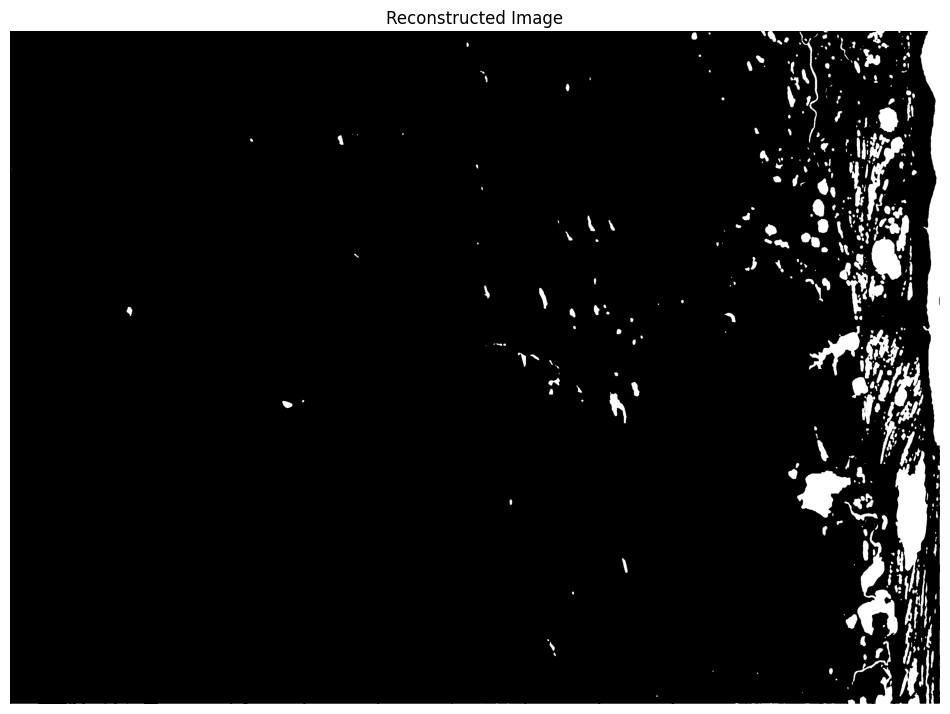

In [388]:
plt.figure(figsize=(12, 12))
plt.imshow(predict_mask, cmap='gray')  
plt.title("Reconstructed Image")
plt.axis('off')  
plt.show()

In [393]:
def plot_data(mask_path):
    plt.figure(figsize=(25, 25))
    pal = [value for color in PALLETE for value in color]
    plt.subplot(1, 2, 2)
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('P')
    mask.putpalette(pal)
    plt.imshow(mask)
    plt.show()

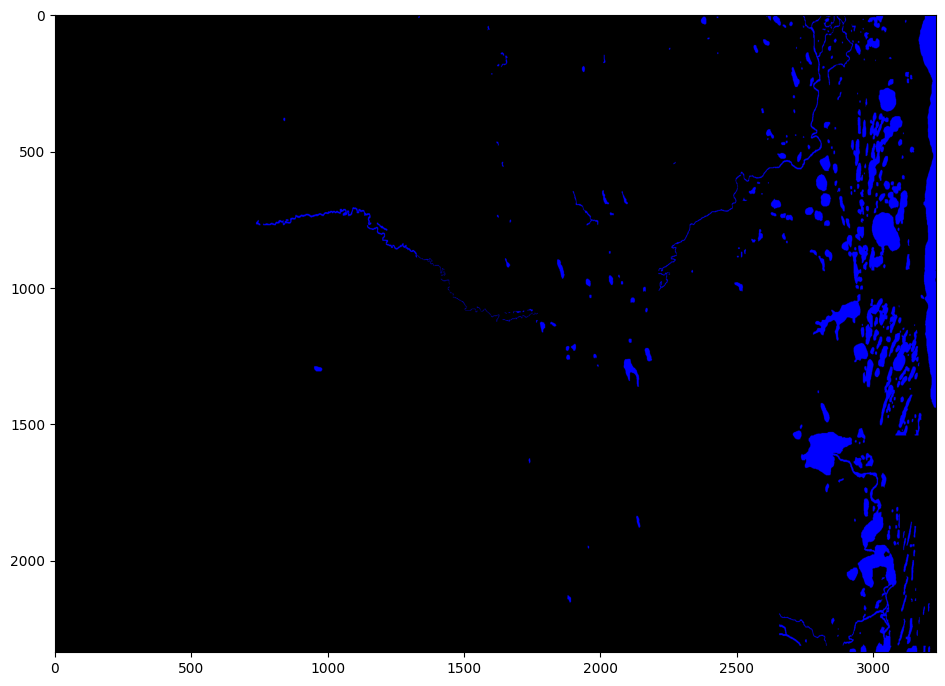

In [392]:
plot_data(f'train/masks/{ID}.tif')

In [14]:
def predict(image_path):
    def create_Buffer(image_path: str, image_size: int = SIZE,
                overlap: int = OVERLAP, image_id: int = OVERLAP) -> None:
        output_folder = "Buffer/"
        split_image(
        image_path=image_path, output_folder=output_folder, tile_size=image_size,
        overlap=OVERLAP, image_id=image_id
        ) 

    image_path = f'train/images/{ID}.tif' 
    create_Buffer(image_path=image_path,
        image_size=SIZE,
        overlap=OVERLAP, image_id=ID
         ) 
    



In [190]:
class water_segmentation:
    class WaterDataset(Dataset):
        def __init__(self, img_path, mask_path, file_names):
            self.img_path = img_path
            self.mask_path = mask_path
            self.file_names = file_names

        def __len__(self):
                return len(self.file_names)

        def __getitem__(self, idx):
            with rasterio.open(self.img_path + self.file_names[idx] + '.tif') as fin:
                image = fin.read()
            image = image_padding(image).astype(np.float32)

            with rasterio.open(self.mask_path + self.file_names[idx] + '.tif') as fin:
                mask = fin.read(1)
            mask = mask_padding(mask)


            # Преобразуем тип данных изображения в float32
            image = image.astype(np.float32)
            image = torch.from_numpy(image)

            # Преобразуем тип данных маски в long
            mask = mask.astype(np.uint8)
            mask = torch.from_numpy(mask).long()
            mask = mask.unsqueeze(0)
            return image, mask
        

    def __init__(self, model_path: str) -> None:
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = torch.jit.load(model_path, map_location=self.DEVICE)
        self.image_path = None
        self.OVERLAP = 0
        self.SIZE = 256


    def predict(self, image_path: str, image_id: str = 0, image_size: int = 256):
        self.image_path = image_path
        self.SIZE = image_size
        with rasterio.open(image_path) as src_image:
                self.IMG_WIDTH = src_image.width
                self.IMG_HEIGHT = src_image.height

        self._split_image(
            image_path=image_path,
            output_folder="Buffer/",
            tile_size=image_size,
            overlap=self.OVERLAP,
            image_id=image_id
        )

        data_list = self._get_data_list(f'Buffer/images/', delete=False)
        predicted_masks = self._predict_tiels(data_list)
        reconstructed_image = self._reconstruct_image_from_tiles(
            tiles=predicted_masks,
            image_height=self.IMG_HEIGHT,
            image_width=self.IMG_WIDTH,
            tile_size=self.SIZE,
            overlap=self.OVERLAP
        )
        reconstructed_image = self._noise(reconstructed_image)

        buffer_directory = 'Buffer/images/'

       
        self._clear_buffer()

        return reconstructed_image



    def _noise(self, data):
        kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        denoised_mask = cv2.morphologyEx(data, cv2.MORPH_CLOSE, kernel_ellipse)
        return denoised_mask

    def _reconstruct_image_from_tiles(self, tiles, image_height, image_width, tile_size, overlap):

        step_size = tile_size - overlap
        reconstructed_image = np.zeros((image_height, image_width), dtype=np.float32)
        weight_map = np.zeros((image_height, image_width), dtype=np.float32)

        index = 0
        for y in range(0, image_height, step_size):
            for x in range(0, image_width, step_size):
                tile = tiles[index]
                h, w = tile.shape


                y1, y2 = y, min(y + tile_size, image_height)
                x1, x2 = x, min(x + tile_size, image_width)


                tile_h, tile_w = y2 - y1, x2 - x1
                tile_crop = tile[:tile_h, :tile_w]


                np.add.at(reconstructed_image, (slice(y1, y2), slice(x1, x2)), tile_crop)
                np.add.at(weight_map, (slice(y1, y2), slice(x1, x2)), 1)

                index += 1

    
        reconstructed_image = (reconstructed_image / np.maximum(weight_map, 1)).astype(np.uint8)

        return reconstructed_image

    def _predict_tiels(self, data_list: list[str]):
        pred_ds = WaterDataset(
            img_path=f'Buffer/images/',
            mask_path=f'Buffer/images/',
            file_names=data_list
        )

        predicted_masks = []
        for i in range(len(data_list)):
            image, _ = pred_ds[i]
            image, original_size = self._image_padding_predict(image)
            image = image.astype(np.float32)
            x_tensor = image.to(self.DEVICE).unsqueeze(0) if isinstance(image, torch.Tensor) else torch.from_numpy(image).to(self.DEVICE).unsqueeze(0)

            pr_mask = self.model(x_tensor)
            pr_mask = pr_mask.squeeze().cpu().detach().numpy()

            binary_output = (pr_mask > 0.5).astype(int)
            binary_output = binary_output[:original_size[0], :original_size[1]]
            predicted_masks.append(torch.from_numpy(binary_output))


        return predicted_masks


    def _image_padding_predict(self, image, target_size: int = SIZE):
        height, width = image.shape[1:3]
        pad_height = max(0, target_size - height)

        pad_width = max(0, target_size - width)
        padded_image = np.pad(image, ((0, 0), (0, pad_height),
                                      (0, pad_width)), mode='reflect')
        
        return padded_image, (height, width)  


    def _get_tiles_with_overlap(self, image_width: int, image_height: int, 
                           tile_size: int, overlap: int) -> List[Window]:

        step_size = tile_size - overlap
        tiles = []
        for y in range(0, image_height, step_size):
            for x in range(0, image_width, step_size):
                window = Window(x, y, tile_size, tile_size)
                # Adjust window if it exceeds the image bounds
                window = window.intersection(Window(0, 0, image_width, image_height))
                tiles.append(window)
        return tiles


    def _save_tiles(self, src_dataset: rasterio.io.DatasetReader, window: Window, 
                  output_folder: str, tile_index: int, image_id: int) -> None:
    
        transform = src_dataset.window_transform(window)
        tile_data = src_dataset.read(window=window)
        
        profile = src_dataset.profile
        profile.update({
            'driver': 'GTiff',
            'height': window.height,
            'width': window.width,
            'transform': transform
        })
        
        output_filename = os.path.join(output_folder, f"tile_{image_id}_{tile_index}.tif")
        with rasterio.open(output_filename, 'w', **profile) as dst:
            dst.write(tile_data)
            

    def _split_image(self, image_path: str, output_folder: str, mask_path: Optional[str] = None, 
                    tile_size: int = 256, overlap: int = 0, image_id: int = 0) -> None:
        with rasterio.open(image_path) as src_image:
            image_width = src_image.width
            image_height = src_image.height
    
            images_folder = os.path.join(output_folder, 'images')
            os.makedirs(images_folder, exist_ok=True)

            tiles = self._get_tiles_with_overlap(image_width, image_height, tile_size, overlap)
            for idx, window in tqdm(enumerate(tiles)):
                self._save_tiles(src_image, window, images_folder, idx, image_id)


    def _image_padding(self, image, target_size: int = SIZE, constant_value: int = 255):
        height, width = image.shape[1:3]
        pad_height = max(0, target_size - height)
        pad_width = max(0, target_size - width)
        padded_image = np.pad(image, 
                              ((0, 0), (0, pad_height), (0, pad_width)), 
                              mode='constant', constant_values=constant_value)
        return padded_image


    def _get_data_list(self, img_path, delete: Optional[bool] = True):
        name = []
        for _, _, filenames in os.walk(img_path): 
            for filename in filenames:
                f = filename.split('.')[0]
                name.append(f)

      
        df = pd.DataFrame(name, columns=['id'])

        # Извлекаем числовую часть и добавляем в отдельный столбец
        df['number'] = df['id'].str.extract(r'_(\d+)$')[0].astype(int)

        # Сортируем по текстовой части и числовой части
        df = df.sort_values(by=['number']).reset_index(drop=True)

        # Получаем отсортированные имена файлов
        sorted_names = df['id'].values

        if delete:
            return np.delete(sorted_names, 0)
        else:
            return sorted_names

    def _clear_buffer(self):
        buffer_path = "Buffer"
        if os.path.exists(buffer_path):
            shutil.rmtree(buffer_path) 
        os.makedirs(buffer_path) 
    

## Для предсказания укажите ссылку на свои файлы

In [ ]:
def save_pred_mask(pred_mask, output_path, transform=None):
    if pred_mask.ndim == 2:  
        pred_mask = pred_mask[np.newaxis, ...]  

    
    profile = {
        'driver': 'GTiff',
        'height': pred_mask.shape[1],
        'width': pred_mask.shape[2],
        'count': pred_mask.shape[0],
        'dtype': 'uint8',  
        'crs': 'EPSG:4326',  
        'transform': transform if transform is not None else from_origin(0, 0, 1, 1),  
        'compress': 'lzw',  
    }

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(pred_mask)


In [191]:
WaterSeg = water_segmentation('model_machine/DeepLabV3.pt')
for id in range(1,4):
    id = str(id)
    pred_mask = WaterSeg.predict(f'test_scoltech/images/{id}.tif', id)
    output_file_path = f'test_submit/{id}.tif'
    save_pred_mask(pred_mask, output_file_path)

200it [00:02, 94.71it/s]
c:\Users\Bigil\OneDrive\Рабочий стол\CP\myenv\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
200it [00:02, 72.89it/s]
c:\Users\Bigil\OneDrive\Рабочий стол\CP\myenv\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
200it [00:02, 96.37it/s] 
c:\Users\Bigil\OneDrive\Рабочий стол\CP\myenv\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an erro

In [197]:
id = str(4)
pred_mask = WaterSeg.predict(f'test_scoltech/images/{id}.tif', id)
output_file_path = f'test_submit/{id}.tif'
save_pred_mask(pred_mask, output_file_path)

200it [00:01, 107.51it/s]
c:\Users\Bigil\OneDrive\Рабочий стол\CP\myenv\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [180]:

def save_pred_mask(pred_mask, output_path, transform=None):
    # Убедитесь, что pred_mask имеет нужный тип и размерность
    if pred_mask.ndim == 2:  # Если маска 2D, добавляем размерность для цветности
        pred_mask = pred_mask[np.newaxis, ...]  # Добавить ось канала

    # Определяем профиль для сохранения
    profile = {
        'driver': 'GTiff',
        'height': pred_mask.shape[1],
        'width': pred_mask.shape[2],
        'count': pred_mask.shape[0],
        'dtype': 'uint8',  # или 'int32', в зависимости от вашего массива
        'crs': 'EPSG:4326',  # Задайте систему координат, если необходимо
        'transform': transform if transform is not None else from_origin(0, 0, 1, 1),  # Параметры преобразования
        'compress': 'lzw',  # Компрессия (по желанию)
    }

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(pred_mask)

# Пример использования:
# Укажите путь, где хотите сохранить файл
output_file_path = f'test_submit/{ID}.tif'

# Сохраните предсказанную маску
save_pred_mask(pred_mask, output_file_path)

c:\Users\Bigil\OneDrive\Рабочий стол\CP\myenv\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [195]:

def plot_data(image_path, mask_path):
    plt.figure(figsize=(25, 25))
    pal = [value for color in PALLETE for value in color]

    plt.subplot(1, 2, 1)
    _, img = convert(image_path)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    with rasterio.open(mask_path) as fin:
        mask = fin.read(1)
    mask = Image.fromarray(mask).convert('P')
    mask.putpalette(pal)
    plt.imshow(mask)
    plt.show()

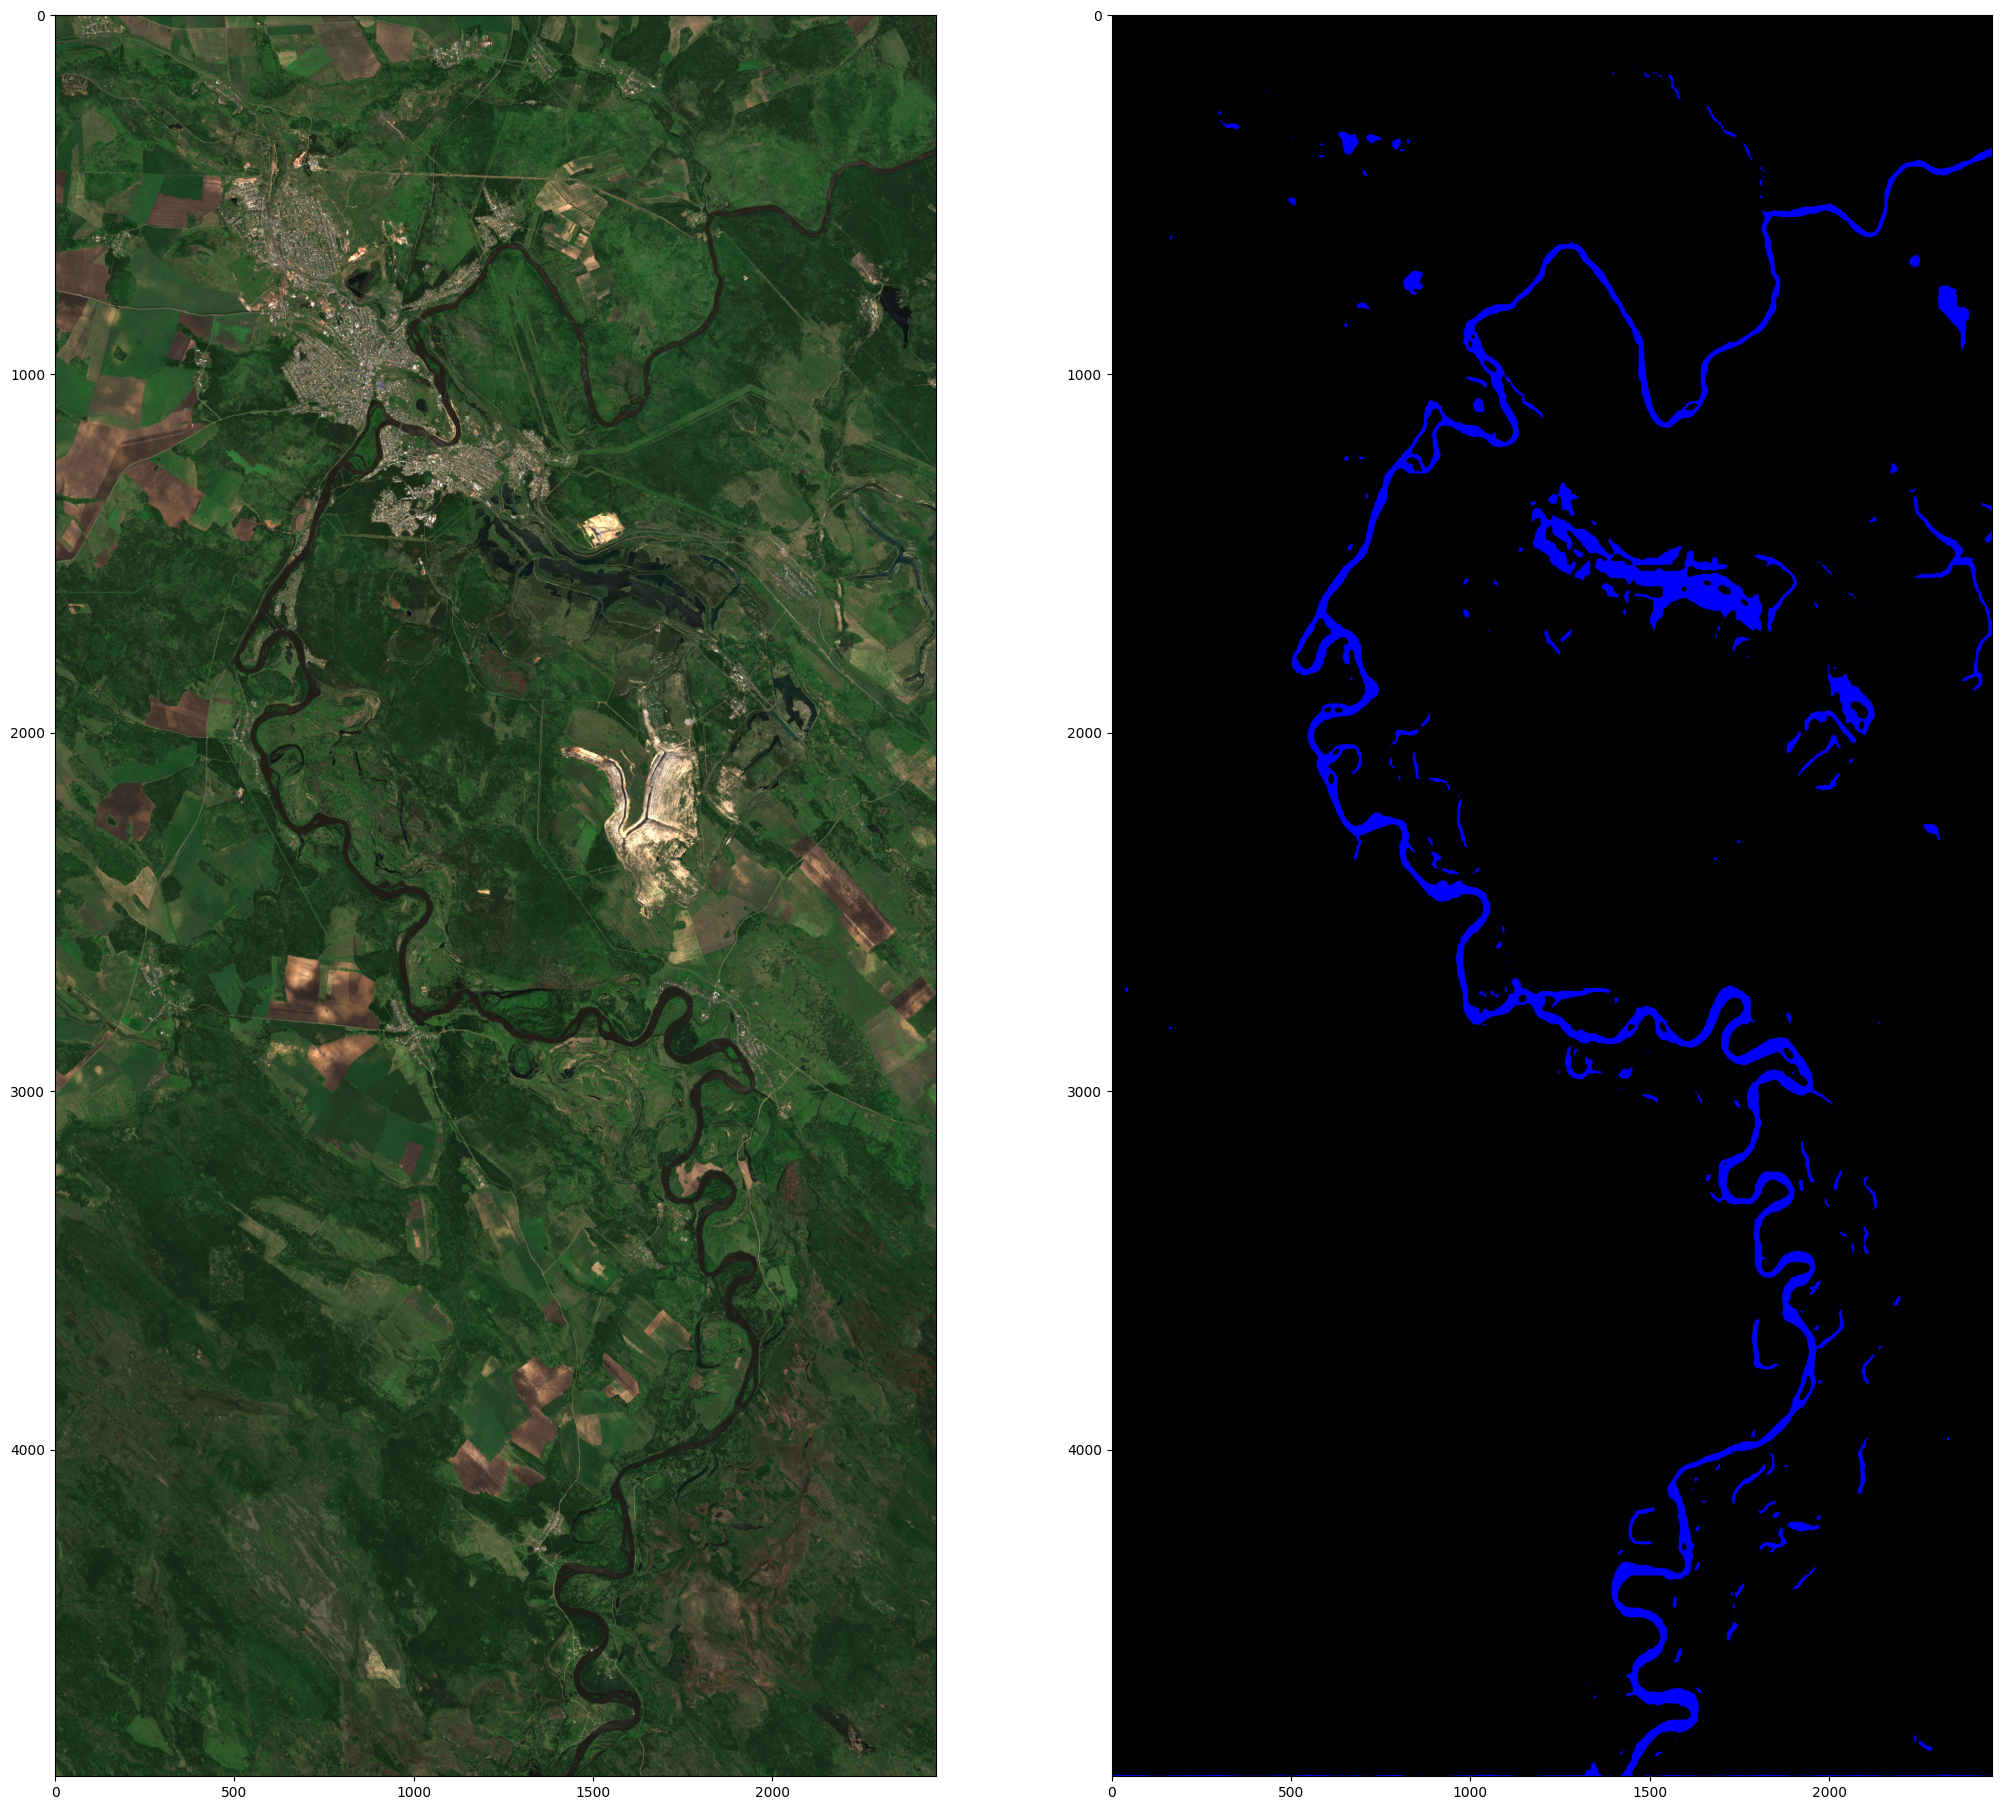

In [199]:
plot_data('test_scoltech/images/3.tif', 'test_submit/images/3.tif')